# Summary
The goal of this assignment is to Predict the total number of Washington D.C. bicycle users on an hourly basis using a dataset with data from 2011 and 2012. The notebook shold be divided in the following sections:

### Part 1: Exploratory Data Analysis
1. Ensuring data quality
2. Plotting clear and meaningful figures
3. Checking possibly redundant variables via correlations


### Part 2: Data Engineering
1. Discussion on missing values and outliers
2. Treatment of text and date features
3. Generation of extra features and studying the influence of combinations of features
4. Giving new insights on what seems relevant for prediction and what does not
5. Use of scikit-learn pipelines to perform transformations

### Part 3: Machine Learning
1. Choosing sensible models (linear and non-linear)
    * Baseline Linear Regression with Initial Variables
    * Linear Regression with New Variables
    * Baseline Random Forest
2. Tuning model parameters with validation
3. Obtaining accurate predictions in test
4. Plotting predictions vs reality for additional insights

# Group Assignment - Bike Sharing
### Group D:
Nadine Raad, Constanca Drago, Guillermo Palacin, Diego Mata, Alexander Gross, Khaled Mahmoud, Orlando Montalvo

## 0. Importing libraries and loading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

Load the data and drop instant since its just an index but starting in 1 instead of 0 creating some problems in the future

In [2]:
df = pd.read_csv('hour.csv').drop('instant', axis=1)

We take a first look at the data

In [3]:
df.head(10)

,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0000,3,13,16
1,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0000,8,32,40
2,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0000,5,27,32
3,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0000,3,10,13
4,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0000,0,1,1
5,2011-01-01,5,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0.24,0.2576,0.75,0.0896,0,1,1
6,2011-01-01,6,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0000,2,0,2
7,2011-01-01,7,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.20,0.2576,0.86,0.0000,1,2,3
8,2011-01-01,8,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0000,1,7,8
9,2011-01-01,9,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.32,0.3485,0.76,0.0000,8,6,14


We look how each variable is distributed

In [4]:
df.describe()

,hr,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.000000,17280.000000,17279.000000,17279.000000,17279.000000,17379.000000,17379.000000,17379.000000
mean,11.546752,0.497071,0.475530,0.627235,0.190114,35.676218,153.786869,189.463088
std,6.914405,0.192474,0.171782,0.193047,0.122378,49.305030,151.357286,181.387599
min,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,6.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,12.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,18.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,23.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


We convert the <span style="color:red">'dteday'</span> feature into a datetime object and convert <span style="color:red">'windspeed'</span> into a float32 type so we can handle it in a different way

In [5]:
df[["dteday"]] = df[["dteday"]].apply(pd.to_datetime)
df['windspeed'] = df['windspeed'].astype('float32')

## Part 1: Exploratory Data Analysis

### a. Undo previous transformations in the Dataset
First, we create a copy of the dataframe. The scaling or other types of transformations have to be done depending on the dataset and based on the training data so we need to undo this transformations

In [6]:
df1 = df.copy()

In [7]:
df1['temp'] = df1['temp']*41
df1['atemp'] = df1['atemp']*50
df1['windspeed'] = df1['windspeed']*67

### b. Describe the types of each features

In [8]:
df1.dtypes

dteday        datetime64[ns]
hr                     int64
weathersit            object
temp                 float64
atemp                float64
hum                  float64
windspeed            float32
casual                 int64
registered             int64
cnt                    int64
dtype: object

### c. Count Nan's
Look for missing values

In [9]:
df1.isna().sum()

dteday          0
hr              0
weathersit    100
temp           99
atemp         100
hum           100
windspeed     100
casual          0
registered      0
cnt             0
dtype: int64

### d. Split the dataset

We split the dataset having Q4 of 2012 as the testset

In [10]:
X = df1.drop(['casual', 'registered', 'cnt'], axis=1)
y = df1['cnt']
X_train, y_train = X[(X['dteday']<'2012-10-1')].copy(), y[(X['dteday']<'2012-10-1')].copy()
X_test, y_test = X[(X['dteday']>='2012-10-1')].copy(), y[(X['dteday']>='2012-10-1')].copy()

### e. Encode the weathersit feature

We check how many values can <span style="color:red">'weathersit'</span> have

In [11]:
X_train['weathersit'].value_counts()

Clear, Few clouds, Partly cloudy, Partly cloudy                                            10130
Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist                                3738
Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds     1254
Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog                                     3
Name: weathersit, dtype: int64


Since there are only 4 types of values, we will encode this categorical variable. We will include this later on the pipeline but will do it here for visualization purposes


In [12]:
X_train['weathersit_cat'] = X_train.weathersit.astype("category", errors='ignore').cat.codes + 1
X_train.head(10)

,dteday,hr,weathersit,temp,atemp,hum,windspeed,weathersit_cat
0,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.84,14.395,0.81,0.0000,1
1,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.02,13.635,0.80,0.0000,1
2,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.02,13.635,0.80,0.0000,1
3,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.84,14.395,0.75,0.0000,1
4,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.84,14.395,0.75,0.0000,1
5,2011-01-01,5,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",9.84,12.880,0.75,6.0032,4
6,2011-01-01,6,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.02,13.635,0.80,0.0000,1
7,2011-01-01,7,"Clear, Few clouds, Partly cloudy, Partly cloudy",8.20,12.880,0.86,0.0000,1
8,2011-01-01,8,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.84,14.395,0.75,0.0000,1
9,2011-01-01,9,"Clear, Few clouds, Partly cloudy, Partly cloudy",13.12,17.425,0.76,0.0000,1


In [13]:
X_train['weathersit_cat'].value_counts()

1    10130
4     3738
3     1254
0       86
2        3
Name: weathersit_cat, dtype: int64

Since we have Nan's they, include them as a new value with the encoding

### f. We plot the all features against each other to observe any trends or relations

We decide to use a scatter plot to spot any relation between features, and in the diagonal, we choose a boxplot to identify any outliers.

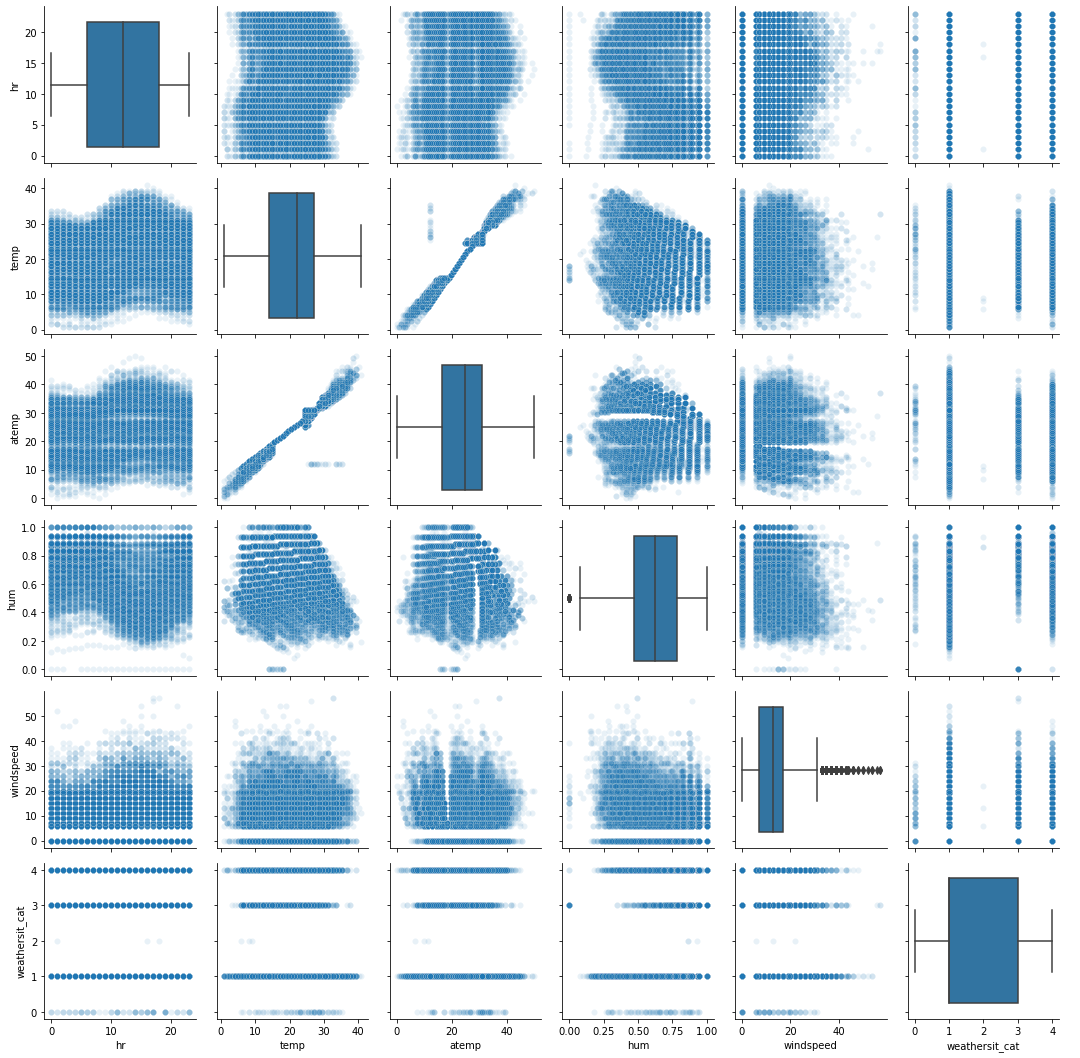

In [14]:
g = sns.PairGrid(X_train[X_train.describe().columns[:9]])
g.map_diag(sns.boxplot)
g.map_offdiag(sns.scatterplot, alpha=0.1)
g.add_legend()

We spotted the following issues:
1) <span style="color:red">'windspeed'</span> appears to have outliers in the high end
2) <span style="color:red">'hum'</span>  appears to have zeros as outliers
3) <span style="color:red">'atemp'</span> appears to have a group of values far away from any relation 

### g. Now, let us plot the histograms per feature

In [15]:
df2 = X_train.drop('weathersit', axis=1).copy()

Text(13, 1850, 'Inconsistent value')

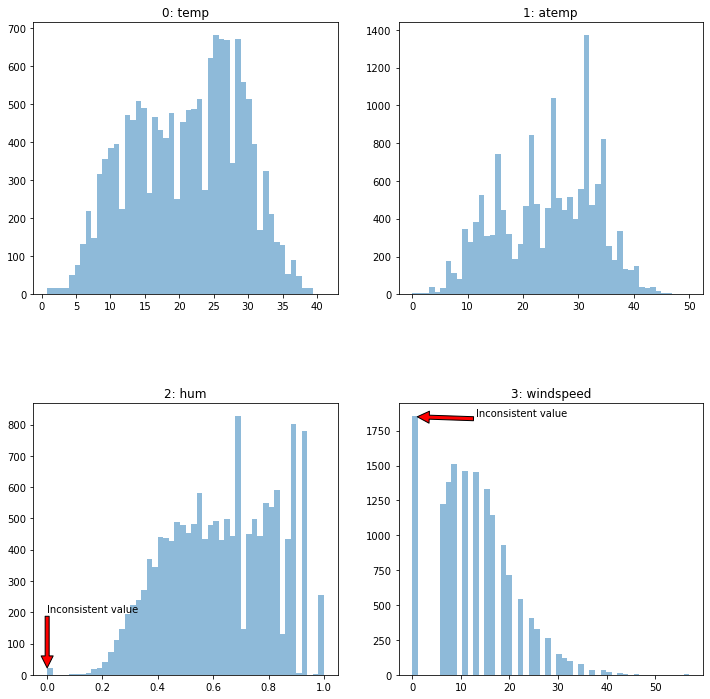

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.subplots_adjust(hspace=0.4)
for i, ax in enumerate(axes.ravel()):
    ax.hist(df2.iloc[:,2:].values[:, i], bins=50, alpha=0.5)
    ax.set_title("{}: {}".format(i, df2.iloc[:,2:].columns[i]))
axes[1,0].annotate(
    'Inconsistent value', # text to display
    xy=(0, 22), # position to point to
    xytext=(0, 200), # position of text
    arrowprops=dict(facecolor='red')
)
axes[1,1].annotate(
    'Inconsistent value', # text to display
    xy=(1, 1850), # position to point to
    xytext=(13, 1850), # position of text
    arrowprops=dict(facecolor='red')
)

We can see the that <span style="color:red">'hum'</span> and <span style="color:red">'windspeed'</span> show some wired values

### h. We plot the correlations between all the features

<AxesSubplot:>

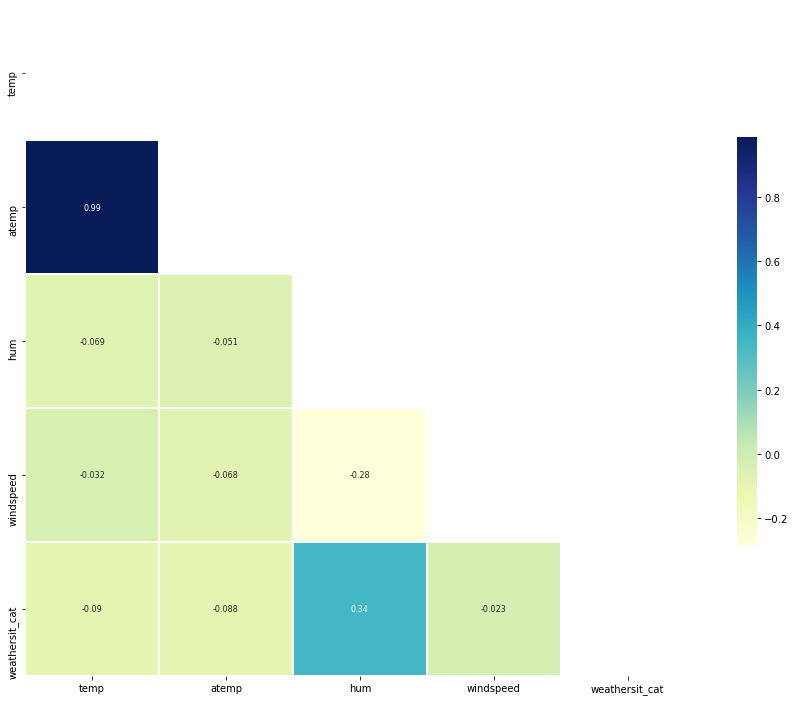

In [17]:
# correlation plot
# Compute the correlation matrix
corr = X_train.iloc[:,2:].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, mask=mask, cmap="YlGnBu", annot=True, annot_kws={"size":8},
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

We can discard the <span style="color:red">'temp'</span> variable because of its high correlation with <span style="color:red">'atemp'</span>

### i. Spotting and handling Outliers and inconsistent values

We created a UDF to spot the outliers to see if we need to do something with them, we are paying special attention to <span style="color:red">'windspeed'</span>

In [18]:
cols_for_distrib = [
    'temp', 'atemp', 'hum', 'windspeed'
]


def outlier_function(train, col_name):
    ''' this function detects first and third quartile and interquartile range for a given column of a dataframe
    then calculates upper and lower limits to determine outliers conservatively
    returns the number of lower and uper limit and number of outliers respectively
    '''
    first_quartile = np.percentile(np.array(train[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(train[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
    second_quartile = np.percentile(np.array(train[col_name].tolist()), 50)
                      
    upper_limit = third_quartile+(1.5*IQR)
    lower_limit = first_quartile-(1.5*IQR)
    outlier_count = 0
                      
    for value in train[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

for x in cols_for_distrib:
    print(f"{x} outlier count: {outlier_function(X_train, x)[2]}")

temp outlier count: 0
atemp outlier count: 0
hum outlier count: 0
windspeed outlier count: 0


#### We didn't found any meeningfull outliers!!!

### j. Hangling inconsistent variables

#### The variable <span style="color:red">'atemp'</span> has inconssitent values

we find where are this strange values

Text(14132, 13.120000000000001, 'next measurment 12.12')

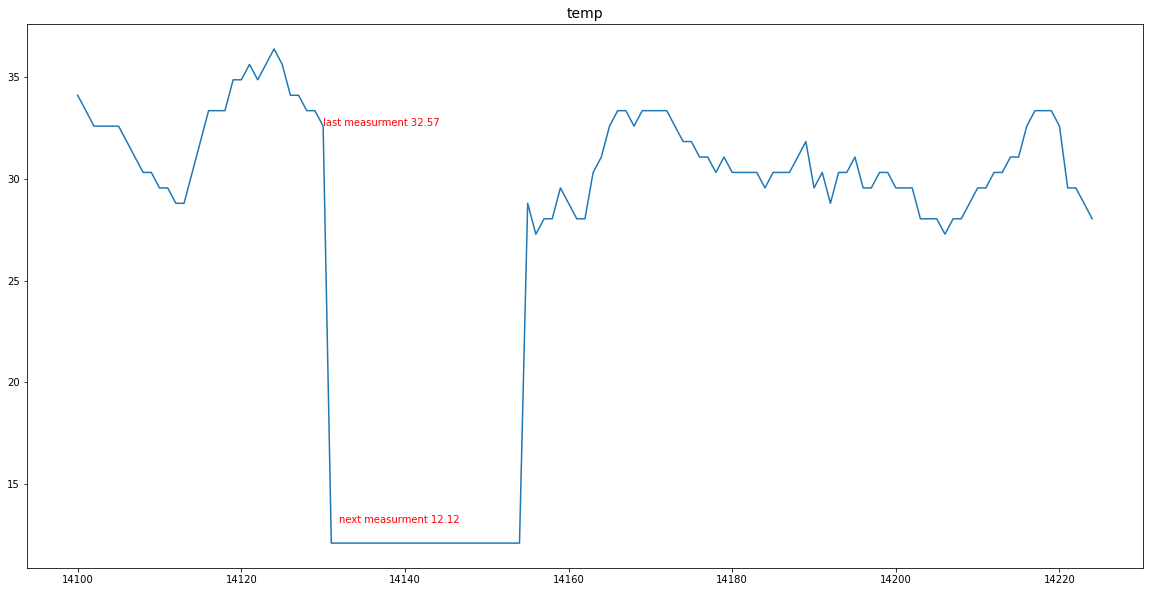

In [19]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(X_train.iloc[14100:14225].index, X_train['atemp'].iloc[14100:14225])
ax.set_title('temp', fontsize=14)
ax.text(X_train.index[14130], X_train['atemp'][14130], f'last measurment {X_train.atemp[14130]:.2f}', color='r')
ax.text(X_train.index[14132], X_train['atemp'][14132]+1, f'next measurment {X_train.atemp[14131]:.2f}', color='r')

It seems the temperature sensor stop working during a period of time. We will handle this as if the sensor was broken, inputting Nan's for now and giving them the same tretment as missing values in the pipeline

In [20]:
X_train.loc[1431:1454,('atemp')] = np.nan

#### The variable <span style="color:red">'hum'</span> has zero (0) as an outlier

In [21]:
print(X_train[(X_train['hum']==0)]['hum'].count())
X_train[(X_train['hum']==0)]

22


,dteday,hr,weathersit,temp,atemp,hum,windspeed,weathersit_cat
1551,2011-03-10,0,"Light Snow, Light Rain + Thunderstorm + Scatte...",13.94,15.910,0.0,16.997900,3
1552,2011-03-10,1,"Light Snow, Light Rain + Thunderstorm + Scatte...",13.94,15.910,0.0,16.997900,3
1553,2011-03-10,2,"Light Snow, Light Rain + Thunderstorm + Scatte...",13.94,15.910,0.0,16.997900,3
1554,2011-03-10,5,"Light Snow, Light Rain + Thunderstorm + Scatte...",14.76,17.425,0.0,12.998000,3
1555,2011-03-10,6,"Light Snow, Light Rain + Thunderstorm + Scatte...",14.76,16.665,0.0,22.002800,3
1556,2011-03-10,7,"Light Snow, Light Rain + Thunderstorm + Scatte...",15.58,19.695,0.0,15.001301,3
1557,2011-03-10,8,"Light Snow, Light Rain + Thunderstorm + Scatte...",15.58,19.695,0.0,19.001200,3
1558,2011-03-10,9,"Light Snow, Light Rain + Thunderstorm + Scatte...",16.40,20.455,0.0,15.001301,3
1559,2011-03-10,10,"Light Snow, Light Rain + Thunderstorm + Scatte...",16.40,20.455,0.0,11.001400,3
1560,2011-03-10,11,"Light Snow, Light Rain + Thunderstorm + Scatte...",16.40,20.455,0.0,16.997900,3


Text(1551, 0.01, 'next measurment 0.00')

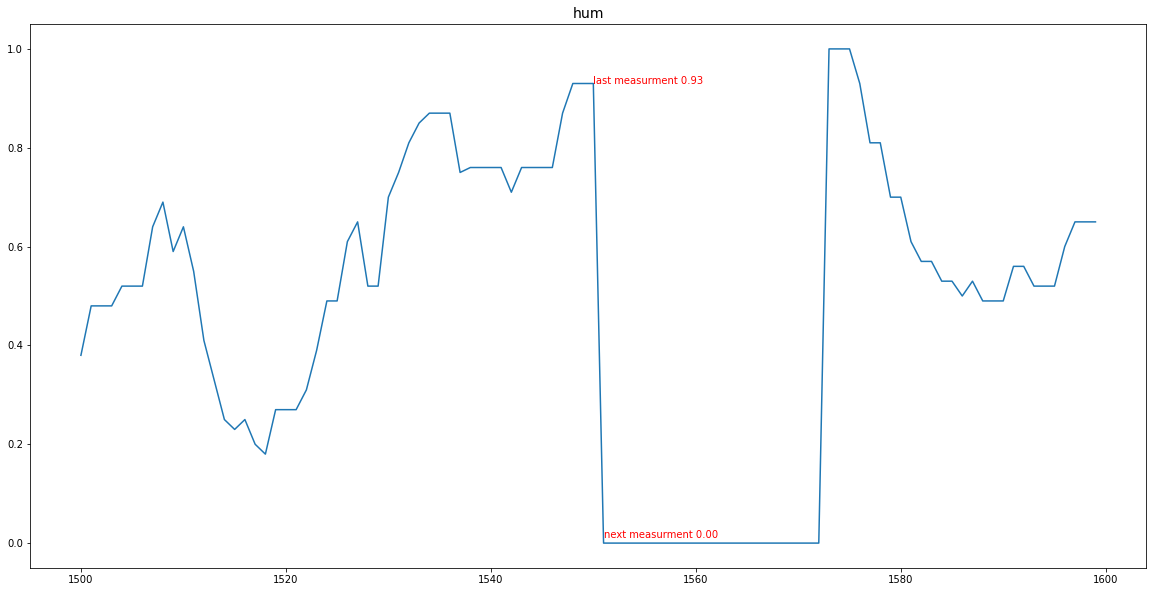

In [22]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(X_train.iloc[1500:1600].index, X_train['hum'].iloc[1500:1600])
ax.set_title('hum', fontsize=14)
ax.text(X_train.index[1550], X_train['hum'][1550], f'last measurment {X_train.hum[1550]:.2f}', color='r')
ax.text(X_train.index[1551], X_train['hum'][1551]+0.01, f'next measurment {X_train.hum[1551]:.2f}', color='r')

Humidity can never be 0%, so we look for these weird values. Once we found them, we realized they appeared to be also a broken sensor for a while. We will proceed in the same way as we did with the <span style="color:red">'atemp'</span> feature 

In [23]:
X_train.loc[1551:1572,('hum')] = np.nan

#### The variable <span style="color:red">'windspeed'</span> has inconssitent values

Text(13, 1850, 'Inconsistent values')

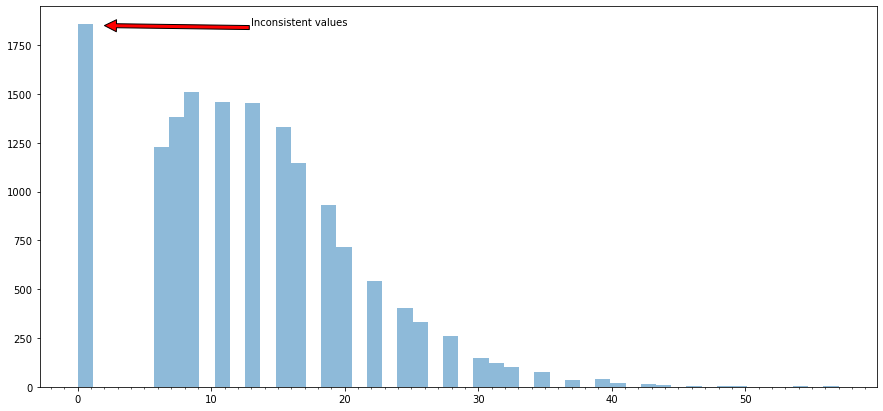

In [24]:
fig, ax = plt.subplots(figsize=(15,7))
ax.hist(X_train['windspeed'], bins=50, alpha=0.5)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.annotate(
    'Inconsistent values', # text to display
    xy=(2, 1850), # position to point to
    xytext=(13, 1850), # position of text
    arrowprops=dict(facecolor='red'))

It seems that the sensor can't catch values smaller than six (6) and drops the measurement to zero (0). We decide its a good idea to create bins, since probably the error is that the sensor takes as zero every value from  xero (0) to six (6)

In [25]:
from sklearn.preprocessing import KBinsDiscretizer
X_train_w = X_train.copy()
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_train_w['windspeed'].fillna(method= 'ffill', inplace= True)
X_train_w['windspeed'] = est.fit_transform(X_train_w[['windspeed']])

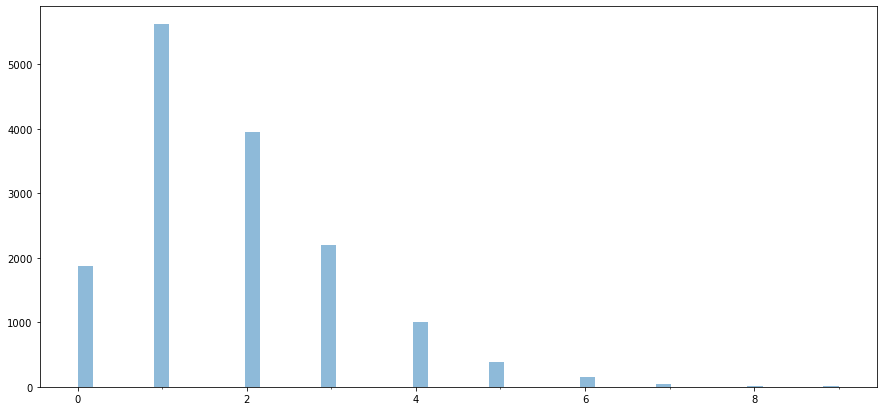

In [26]:
fig, ax = plt.subplots(figsize=(15,7))
ax.hist(X_train_w['windspeed'], bins=50, alpha=0.5)
ax.xaxis.set_minor_locator(MultipleLocator(1))

Now we can see how the distribution looks more consistent. We will incoporate this transformation into the pipeline. In order to separate this column from the rest we will change its type to float32. At the beggining of the notebook ;)

In [27]:
df1.dtypes

dteday        datetime64[ns]
hr                     int64
weathersit            object
temp                 float64
atemp                float64
hum                  float64
windspeed            float32
casual                 int64
registered             int64
cnt                    int64
dtype: object

### k. Handling Nan's 

We will handle the Nan's using Iterativeimputer() in the pipeline

## Part 2: Data Engineering

### a. We create severall UDF so we can test features easier

#### IMPORTANT: Since <span style="color:red">'cnt'</span> is equal to the sum of <span style="color:red">'casual'</span> and <span style="color:red">'registered'</span> we will try a double approach: 

##### 1) A model that predicts <span style="color:red">'cnt'</span> 
##### 2) Two models that predicts <span style="color:red">'casual'</span> and <span style="color:red">'registered'</span>  and then adds them up to obtain <span style="color:red">'cnt'</span> 

First we create a UDF that receives a dataframe, an ML algosithim and a type of Scaler and does the following:

In [28]:
# Define a Pipeline 
def create_pipeline(X_train, scaler, algo): #receives a Dataframe a type of scale and a ML algorithim
    
    ''' 
    This function prepares a pipeline to train an ML algorithm.
    First, it takes the dataframe and includes each feature into three different categories:
    1) categorical_features: Categorical variables made of string
    2) numeric_features: Numeric features (float64 & int64)
    3) bins_features: Numeric features (float32) that needs to be put into bins
    Finally, it replaces Nan's, scales the variables and creates the pipeline for the ML algorithm ready to be trained.
    '''
    
    categorical_features = X_train.select_dtypes(include=["object"]).columns
    numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns
    bins_features = X_train.select_dtypes(include=["float32"]).columns
    
    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(sparse=False, handle_unknown="ignore")),
    ])

    # Define numerical pipeline
    num_pipe = Pipeline([
        ("imputer", IterativeImputer(random_state=42)),
        ("scaler", scaler),

    ])

     # Define the binning pipeline
    bins_pipe = Pipeline([
        ("imputer", IterativeImputer(random_state=42)),
        ('bins', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')),
        ("scaler", scaler),

    ])
    # Assemble column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", cat_pipe, categorical_features),
            ("num", num_pipe, numeric_features),
            ('bins', bins_pipe, bins_features),
        ],
    )
    
    pipe = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("LinReg", algo)
        ]
    )
    return pipe

We create a second UDF to train and test the model with one target variable

In [29]:
def test_model_cnt(X_train1, y_train, X_test1, y_test, scaler, algo):
    ''' 
    This function receives four DF to train and test an algorithm with one target variable.
    It creates a pipeline using the training set, the ML algorithm and a Scaler
    first; it creates the pipeline with the chosen algorithm and scaler, then it fits and predict the results.
    Finally, it calculates the RMSE and R squared and return them as a tuple 
    '''
    pipe = create_pipeline(X_train1, scaler, algo)
    pipe.fit(X_train1, y_train)
    y_hat = pipe.predict(X_test1)
    RMSE = mean_squared_error(y_test, y_hat)**0.5
    R2 =  r2_score(y_test, y_hat)
    return RMSE, R2

We create a third UDF that prepares and splits a DF for a one target variable

In [30]:
def split_new_df_cnt(df):
    ''' 
    This function receives DF, prepares the data given the insights we obtain before 
    and then splits into train and test set for a one target varible
    '''
    df.loc[1432:1455,('atemp')] = np.nan #Handle inconsistent values
    df.loc[1552:1573,('hum')] = np.nan #Handle inconsistent values
    X = df.drop(['casual', 'registered', 'cnt'], axis=1) #creates x
    y = df['cnt'] #creates y
    X_train, y_train = X[(X['dteday']<'2012-10-1')].copy(), y[(X['dteday']<'2012-10-1')].copy() #Splits x into train test
    X_test, y_test = X[(X['dteday']>='2012-10-1')].copy(), y[(X['dteday']>='2012-10-1')].copy() #Splits y into train test
    X_train.drop('dteday', axis=1, inplace=True) #drops dteday column since we will not use it anymore 
    X_test.drop('dteday', axis=1, inplace=True) #drops dteday column since we will not use it anymore
    return X_train, y_train, X_test, y_test

We create a fourth UDF to train and test the model with two target variables

In [31]:
def test_model_two_y(X_train, y_casual_train, y_registered_train, X_test, y_test, scaler, algo):
    ''' 
    This function receives four DF to train and test an algorithm with two target variables.
    It creates a pipeline using the training set, the ML algorithm and a Scaler
    first; it creates the pipeline with the chosen algorithm and scaler for each target variabel, then it fits and predict the results.
    Finally, it add both results and calculates the RMSE and R squared and return them as a tuple 
    '''
    pipe = create_pipeline(X_train, scaler, algo)
    pipe.fit(X_train, y_casual_train)
    y_casual_hat = pipe.predict(X_test)
    pipe.fit(X_train, y_registered_train)
    y_registered_hat = pipe.predict(X_test)
    y_hat = y_casual_hat + y_registered_hat
    RMSE = mean_squared_error(y_test, y_hat)**0.5
    R2 =  r2_score(y_test, y_hat)
    return RMSE, R2

We create a fifth UDF that prepares and splits a DF for a two target variables

In [32]:
def split_new_df_two_y(df):
    ''' 
    This function receives DF, prepares the data given the insights we obtain before 
    and then splits into train and test set for a two target varible
    '''
    df.loc[1432:1455,('atemp')] = np.nan #Handle inconsistent values
    df.loc[1552:1573,('hum')] = np.nan #Handle inconsistent values
    X = df.drop(['casual', 'registered', 'cnt'], axis=1)
    y = df['cnt']
    y_casual = df['casual']
    y_registered = df['registered']
    X_train = X[(X['dteday']<'2012-10-1')].copy()
    X_test = X[(X['dteday']>='2012-10-1')].copy()
    y_casual_train = y_casual[(X['dteday']<'2012-10-1')].copy()
    y_registered_train = y_registered[(X['dteday']<'2012-10-1')].copy()
    y_test = y[(X['dteday']>='2012-10-1')].copy()
    X_train.drop('dteday', axis=1, inplace=True)
    X_test.drop('dteday', axis=1, inplace=True)
    return X_train, y_casual_train, y_registered_train, X_test, y_test

In [33]:
def try_all(df):
    ''' 
    This function takes a DF, splits it using both approaches and test each approch with a linear model and a Random Forest model.
    Finally, it returns a DF with the RMSE and r2 for each approach and each model
    '''
    #Run a linear regression model with cnt as target variable 
    X_train, y_train, X_test, y_test = split_new_df_cnt(df)
    lr_rmse_1, lr_r2_1 = test_model_cnt(X_train, y_train, X_test, y_test, MinMaxScaler(), LinearRegression())
    
    #Run a Random Forest regression model with cnt as target variable
    X_train, y_train, X_test, y_test = split_new_df_cnt(df)
    rf_rmse_1, rf_r2_1 = test_model_cnt(X_train, y_train, X_test, y_test, MinMaxScaler(), RandomForestRegressor(random_state=42))
    
    #Run two linear regression models with casual and registered as target variables 
    X_ta, y_c_ta, y_r_ta, X_te, y_te = split_new_df_two_y(df)
    lr_rmse_2, lr_r2_2 = test_model_two_y(X_ta, y_c_ta, y_r_ta, X_te, y_te, MinMaxScaler(), LinearRegression())
    
    #Run two Random Forest regression models with casual and registered as target variables  
    X_ta, y_c_ta, y_r_ta, X_te, y_te = split_new_df_two_y(df)
    rf_rmse_2, rf_r2_2 = test_model_two_y(X_ta, y_c_ta, y_r_ta, X_te, y_te, MinMaxScaler(), RandomForestRegressor(random_state=42))
    
    s = {'RMSE': [lr_rmse_1, rf_rmse_1, lr_rmse_2, rf_rmse_2], 'r2': [lr_r2_1, rf_r2_1, lr_r2_2, rf_r2_2]}
    
    score = pd.DataFrame(data=s, index=["linear_one_var", "random_forest_one_var", "linear_two_var", "random_forest_two_var"])
    
    return score

### b. Quick linear regression model as a benchmark

We train and test a basic linear regression model using a MinMaxScaler to predict <span style="color:red">'cnt'</span>

In [34]:
X_train, y_train, X_test, y_test = split_new_df_cnt(df1)
test_model_cnt(X_train, y_train, X_test, y_test, MinMaxScaler(), LinearRegression())

(186.49657383865255, 0.14410373743220395)

We train and test a basic Random Forest model using a MinMaxScaler to predict <span style="color:red">'cnt'</span>

In [35]:
X_train, y_train, X_test, y_test = split_new_df_cnt(df1)
test_model_cnt(X_train, y_train, X_test, y_test, MinMaxScaler(), RandomForestRegressor(random_state=42))

(145.2483134950383, 0.4808395366673768)

We train and test a basic linear regression model using a MinMaxScaler to predict <span style="color:red">'casual'</span> and <span style="color:red">'registered'</span> and finally <span style="color:red">'cnt'</span>

In [36]:
X_ta, y_c_ta, y_r_ta, X_te, y_te = split_new_df_two_y(df1)
test_model_two_y(X_ta, y_c_ta, y_r_ta, X_te, y_te, MinMaxScaler(), LinearRegression())

(186.48008052934898, 0.1442551175598099)

We train and test a basic Random Forest model using a MinMaxScaler to predict <span style="color:red">'casual'</span> and <span style="color:red">'registered'</span> and finally <span style="color:red">'cnt'</span>

In [37]:
X_ta, y_c_ta, y_r_ta, X_te, y_te = split_new_df_two_y(df1)
test_model_two_y(X_ta, y_c_ta, y_r_ta, X_te, y_te, MinMaxScaler(), RandomForestRegressor(random_state=42))

(145.06797713611402, 0.48212788742618407)

We now do a try all to confirm everything is working correctly

In [38]:
try_all(df1)

,RMSE,r2
linear_one_var,186.496574,0.144104
random_forest_one_var,145.248313,0.480840
linear_two_var,186.480081,0.144255
random_forest_two_var,145.067977,0.482128


### c. Try droping the <span style="color:red">'temp'</span> variable

In [39]:
df3 = df1.drop('temp', axis=1).copy()

In [40]:
try_all(df3)

,RMSE,r2
linear_one_var,185.723361,0.151186
random_forest_one_var,145.881299,0.476305
linear_two_var,185.721742,0.151201
random_forest_two_var,145.417441,0.479630


#### It Improved the Linear Model but not the Random Forest. Since it's highly correlated with <span style="color:red">'atemp'</span> we delete it to make a simpler model

### d. Creating new features

We start by creating a new DF out of the df3 (without the <span style="color:red">'temp'</span> feature)

In [41]:
df4 = df3.copy()
df4.head(5)

,dteday,hr,weathersit,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",14.395,0.81,0.0,3,13,16
1,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",13.635,0.80,0.0,8,32,40
2,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",13.635,0.80,0.0,5,27,32
3,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",14.395,0.75,0.0,3,10,13
4,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",14.395,0.75,0.0,0,1,1


In [42]:
df4.dtypes

dteday        datetime64[ns]
hr                     int64
weathersit            object
atemp                float64
hum                  float64
windspeed            float32
casual                 int64
registered             int64
cnt                    int64
dtype: object

#### Creating new feutures using Polynomial 

In [43]:
from sklearn.preprocessing import PolynomialFeatures

iter_impu = IterativeImputer(random_state=42)
df4.iloc[:,3:6] = iter_impu.fit_transform(df4.iloc[:,3:6])
df4['windspeed'] = est.fit_transform(df4[['windspeed']]) #call the algorithim to create the bins
X_cat = df4.iloc[:,3:6] # select numerical values of the fatures that has to do with the weather
poly = PolynomialFeatures(interaction_only=True, include_bias = False)
interactions = pd.DataFrame(poly.fit_transform(X_cat))
df4 = pd.concat([df4, interactions], axis=1)

In [44]:
df4.tail(5)

,dteday,hr,weathersit,atemp,hum,windspeed,casual,registered,cnt,0,1,2,3,4,5
17374,2012-12-31,19,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",12.880,0.60,1.0,11,108,119,12.880,0.60,1.0,7.72800,12.880,0.60
17375,2012-12-31,20,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",12.880,0.60,1.0,8,81,89,12.880,0.60,1.0,7.72800,12.880,0.60
17376,2012-12-31,21,"Clear, Few clouds, Partly cloudy, Partly cloudy",12.880,0.60,1.0,7,83,90,12.880,0.60,1.0,7.72800,12.880,0.60
17377,2012-12-31,22,"Clear, Few clouds, Partly cloudy, Partly cloudy",13.635,0.56,1.0,13,48,61,13.635,0.56,1.0,7.63560,13.635,0.56
17378,2012-12-31,23,"Clear, Few clouds, Partly cloudy, Partly cloudy",13.635,0.65,1.0,12,37,49,13.635,0.65,1.0,8.86275,13.635,0.65


In [45]:
try_all(df4)

,RMSE,r2
linear_one_var,184.883937,0.158842
random_forest_one_var,146.252805,0.473634
linear_two_var,184.878712,0.158889
random_forest_two_var,145.357641,0.480058


##### It does not improve very much the model, therefore we will not use these new features

We create a new df from the df3 (one df before)

In [46]:
df5 = df3.copy()
df5.head(5)

,dteday,hr,weathersit,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",14.395,0.81,0.0,3,13,16
1,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",13.635,0.80,0.0,8,32,40
2,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",13.635,0.80,0.0,5,27,32
3,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",14.395,0.75,0.0,3,10,13
4,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",14.395,0.75,0.0,0,1,1


In [47]:
df5.dtypes

dteday        datetime64[ns]
hr                     int64
weathersit            object
atemp                float64
hum                  float64
windspeed            float32
casual                 int64
registered             int64
cnt                    int64
dtype: object

#### Creating Datetime features

In [48]:
df5["day"] = df5["dteday"].dt.day
df5["month"] = df5["dteday"].dt.month
df5["year"] = df5["dteday"].dt.year
df5["doy"] = df5["dteday"].dt.dayofyear
df5["day_of_week"] = df5["dteday"].dt.dayofweek
weekend = (df5["day_of_week"] == 0) | (df5["day_of_week"] == 5)
df5["weekend"] = np.where(weekend , 1, 0)
spring = range(80, 172)
summer = range(172, 264)
fall = range(264, 355)
winter = range(0, 80)

def season_data(row):
    day_of_year = row.doy
    
    if (day_of_year in spring):
        return "spring"
    elif (day_of_year in summer):
        return "summer"
    elif (day_of_year in fall):
        return "fall"
    elif (day_of_year in winter):
        return "winter"

df5["season"] = df5.apply(season_data, axis=1)

In [49]:
df5.head(5)

,dteday,hr,weathersit,atemp,hum,windspeed,casual,registered,cnt,day,month,year,doy,day_of_week,weekend,season
0,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",14.395,0.81,0.0,3,13,16,1,1,2011,1,5,1,winter
1,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",13.635,0.80,0.0,8,32,40,1,1,2011,1,5,1,winter
2,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",13.635,0.80,0.0,5,27,32,1,1,2011,1,5,1,winter
3,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",14.395,0.75,0.0,3,10,13,1,1,2011,1,5,1,winter
4,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",14.395,0.75,0.0,0,1,1,1,1,2011,1,5,1,winter


### Plotting new features

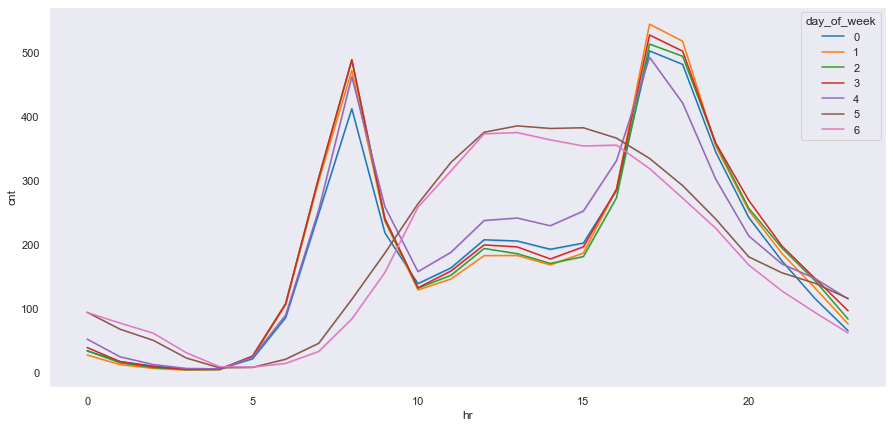

In [50]:
plt.figure(figsize=(15,7))
sns.set(style='dark')
sns.set_context(font_scale=5)
sns.lineplot(x='hr',y='cnt',hue='day_of_week',data=df5, palette="tab10", ci=0)
plt.show()

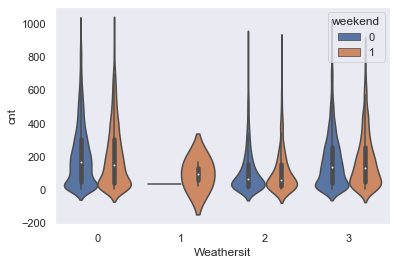

In [51]:
# sns.set(font_scale = 1)
# ax = sns.violinplot(x="weathersit", y="cnt", hue="weekend",
#                      data=df5, palette="Set2", split=True)
ax = sns.violinplot(x=df5['weathersit'].dropna().astype('category').cat.codes, y=df5['cnt'], hue=df5['weekend'])
ax.set_ylabel("cnt")
ax.set_xlabel("Weathersit")
plt.show()

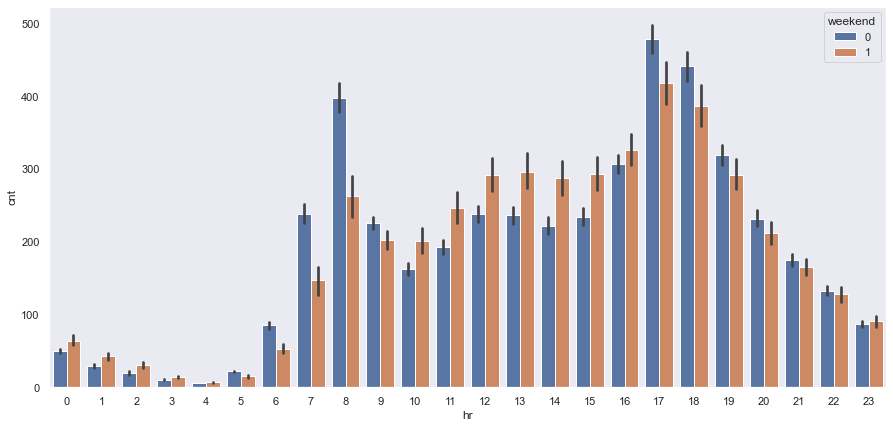

In [52]:
plt.figure(figsize=(15,7))
sns.set(style='dark')
sns.barplot(x="hr", y="cnt", hue="weekend", data=df5)
plt.show()

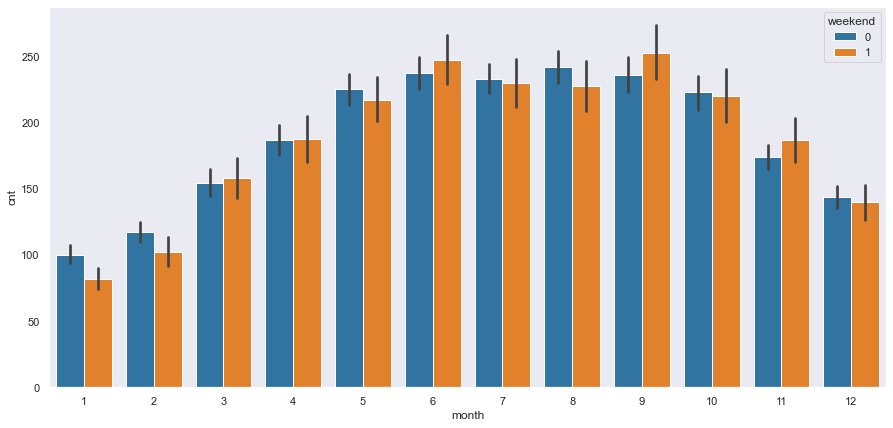

In [53]:
plt.figure(figsize=(15,7))

sns.set(style='dark')
sns.barplot(x="month", y="cnt", hue="weekend", data=df5, palette="tab10")
plt.show()

Let's test the model with the new features!

In [54]:
try_all(df5)

,RMSE,r2
linear_one_var,167.915608,0.306156
random_forest_one_var,93.460618,0.785050
linear_two_var,167.928320,0.306051
random_forest_two_var,86.603673,0.815434


#### It improved! we are leaving this features

We will now try to use this features but encoded in dummy variables to seen how they behave

In [55]:
df6 = df5.copy()

After several tries it is best to encode only the <span style="color:red">'day'</span> and <span style="color:red">'month'</span>

In [56]:
df6 = pd.get_dummies(df6, columns = [
                                    "day", 
                                     "month", 
                                     #"year",
                                     #"day_of_week"
                                    ])

In [57]:
print(len(df6.columns))
df6.columns

57


Index(['dteday', 'hr', 'weathersit', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt', 'year', 'doy', 'day_of_week', 'weekend', 'season',
       'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8',
       'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15',
       'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22',
       'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29',
       'day_30', 'day_31', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12'],
      dtype='object')

We now have 57 features!

In [58]:
try_all(df6)

,RMSE,r2
linear_one_var,167.861528,0.306603
random_forest_one_var,90.221078,0.799693
linear_two_var,167.860960,0.306608
random_forest_two_var,84.676571,0.823556


#### It Improved! therefore we leave the new features

### Part 3: Machine Learning

#### a. Let's see which is the best algorithm to work with

In [59]:
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet

algo = [
          BayesianRidge(), 
          GradientBoostingRegressor(random_state=42), 
          ElasticNet(random_state=42), 
          RandomForestRegressor(random_state=42),
          XGBRegressor(), 
         ]

r2_max = 0
best_algo = ""

for a in algo:
    
    X_ta, y_c_ta, y_r_ta, X_te, y_te = split_new_df_two_y(df6)
    RMSE, R2 = test_model_two_y(X_ta, y_c_ta, y_r_ta, X_te, y_te, MinMaxScaler(), a)
    
    if R2 > r2_max:
        r2_max = R2
        best_algo = a
        
print(f'The best algorithm is {best_algo} with a r2={r2_max:.4f}')

The best algorithm is XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None) with a r2=0.8663


#### The best algorithm is XGBRegressor() with a r2= 0.08663

#### b. Identifiying the best Scaler

In [60]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer

scaler = [MinMaxScaler(), 
          MaxAbsScaler(), 
          StandardScaler(), 
          RobustScaler(), 
          Normalizer(), 
          QuantileTransformer(), 
         ]

r2_max = 0
best_scaler = ""

for s in scaler:
    X_ta, y_c_ta, y_r_ta, X_te, y_te = split_new_df_two_y(df6)
    RMSE, R2 = test_model_two_y(X_ta, y_c_ta, y_r_ta, X_te, y_te, s, best_algo)
    
    if R2 > r2_max:
        r2_max = R2
        best_scaler = s
        
print(f'The best scaler is {best_scaler} with a r2={r2_max:.4f}')

The best scaler is StandardScaler() with a r2=0.8664


#### The best scaler is StandardScaler() with a r2= 0.08664

#### c. Now we will prepare to improve hyperparameters

We create a new pipeline with the insights we have obtain so far: Best Algorithim, Best Scaler and that the two model approach is better than the one target approach

In [61]:
X_train, y_train, X_test, y_test = split_new_df_cnt(df6)
categorical_features = X_train.select_dtypes(include=["object"]).columns
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns
bins_features = X_train.select_dtypes(include=["float32"]).columns

In [62]:
# Define categorical pipeline
cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(sparse=False, handle_unknown="ignore")),
    ])

# Define numerical pipeline
num_pipe = Pipeline([
    ("imputer", IterativeImputer(random_state=42)),
    ("scaler", best_scaler),
])

 # Define the binning pipeline
bins_pipe = Pipeline([
    ("imputer", IterativeImputer(random_state=42)),
    ('bins', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')),
    ("scaler", best_scaler),

])

# Assemble column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", cat_pipe, categorical_features),
        ("num", num_pipe, numeric_features),
        ('bins', bins_pipe, bins_features),
    ],
)

pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("Algo", best_algo)
    ]
)

We now create the parameters for the Grid Search taking into account we are using XGBRegressor

In [63]:
param_grid_casual = {
  
 'Algo__n_estimators': [20, 40, 70],
 'Algo__max_depth': [10, 20, None],
 'Algo__learning_rate': [0.005, 0.01, 0.05],
 'Algo__min_child_weight': [0.0001,0.001,0.01], 
 'Algo__gamma': [10, 50, 100],      
 'Algo__reg_alpha': [0.05, 1, 5],
    
}

In [64]:
param_grid = {
  
 'Algo__n_estimators': [80, 150, 180],
 'Algo__max_depth': [10, 20, None],
 'Algo__learning_rate': [0.05, 0.10, 0.15],
 'Algo__min_child_weight': [0.01,1,1000], 
 'Algo__gamma': [0, 1, 10],      
 'Algo__reg_alpha': [0.05, 1, 5],
    
}

We now create a new UDF to split the DF but this time we need to have also the 'y_test' for each of the target variables, so we can include the Grid Search 

In [65]:
from sklearn.model_selection import GridSearchCV

In [66]:
def split_new_df_two_y_separate(df):
    df.loc[1432:1455,('atemp')] = np.nan #Handle inconsistent values
    df.loc[1552:1573,('hum')] = np.nan #Handle inconsistent values
    X = df.drop(['casual', 'registered', 'cnt'], axis=1)
    y = df['cnt']
    y_casual = df['casual']
    y_registered = df['registered']
    X_train = X[(X['dteday']<'2012-10-1')].copy()
    X_test = X[(X['dteday']>='2012-10-1')].copy()
    y_casual_train = y_casual[(X['dteday']<'2012-10-1')].copy()
    y_registered_train = y_registered[(X['dteday']<'2012-10-1')].copy()
    y_test = y[(X['dteday']>='2012-10-1')].copy()
    y_test_casual =  y_casual[(X['dteday']>='2012-10-1')].copy()
    y_test_registered =  y_registered[(X['dteday']>='2012-10-1')].copy()
    X_train.drop('dteday', axis=1, inplace=True)
    X_test.drop('dteday', axis=1, inplace=True)
    return X_train, y_casual_train, y_registered_train, X_test, y_test, y_test_casual, y_test_registered

We split the best data frame (df6)

In [67]:
X_train, y_casual_train, y_registered_train, X_test, y_test, y_test_casual, y_test_registered = split_new_df_two_y_separate(df6)

We do the Grid Search for the Casual model

In [68]:
grid_casual = GridSearchCV(
    pipe, # you can pass a pipeline here too!
    param_grid_casual,
    scoring="r2",
    cv=5,
    n_jobs=-2,
    verbose=3
)
grid_casual.fit(X_train, y_casual_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         Index(['weathersit', 'season'], dtype='object')),
                                                                        ('num',
                                                         

In [69]:
grid_casual.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['weathersit', 'season'], dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(random_state=42)),
                                                                  ('scaler',
                         

We now check for the best parameters for this model

In [70]:
grid_casual.best_params_

{'Algo__gamma': 50,
 'Algo__learning_rate': 0.05,
 'Algo__max_depth': None,
 'Algo__min_child_weight': 0.0001,
 'Algo__n_estimators': 70,
 'Algo__reg_alpha': 5}

We do the Grid Search for the Registered model

In [71]:
grid_registered = GridSearchCV(
    pipe, # you can pass a pipeline here too!
    param_grid,
    scoring="r2",
    cv=5,
    n_jobs=-2,
    verbose=3
)
grid_registered.fit(X_train, y_registered_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         Index(['weathersit', 'season'], dtype='object')),
                                                                        ('num',
                                                         

We now check for the best parameters for this model

In [72]:
grid_registered.best_params_

{'Algo__gamma': 1,
 'Algo__learning_rate': 0.15,
 'Algo__max_depth': None,
 'Algo__min_child_weight': 0.01,
 'Algo__n_estimators': 80,
 'Algo__reg_alpha': 5}

In [73]:
grid_registered.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['weathersit', 'season'], dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(random_state=42)),
                                                                  ('scaler',
                         

#### Now we test this new models

In [74]:
y_hat_casual = grid_casual.predict(X_test)
y_hat_registered = grid_registered.predict(X_test)

casual_r2 = r2_score(y_test_casual, y_hat_casual)
registered_r2 = r2_score(y_test_registered, y_hat_registered)

y_hat = y_hat_casual + y_hat_registered
total_r2 = r2_score(y_test, y_hat)
print(f'The r2 of the model for casual users has an r2 of {casual_r2:.4f}') 
print(f'The r2 of the model for registered users has an r2 of {registered_r2:.4f}')
print(f'The total r2 is {total_r2:.4f} ')

The r2 of the model for casual users has an r2 of 0.7868
The r2 of the model for registered users has an r2 of 0.8453
The total r2 is 0.8573 


### The model Improved!!! We now have the final model

Now we plot the predictions vs the actual values. They should be very close to the diagonal 

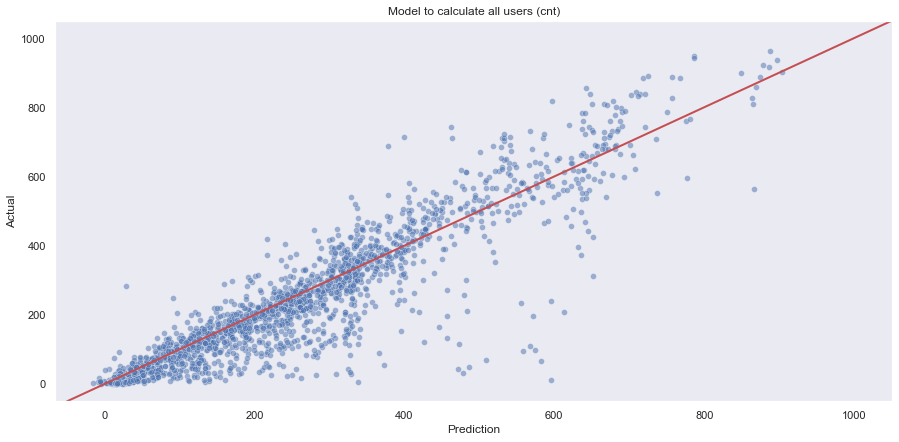

In [75]:
plt.figure(figsize=(15,7))
sns.scatterplot(x=y_hat, y=y_test, alpha=0.5)
plt.axline((0, 0), (1000, 1000), linewidth=2, color='r')
plt.xlabel('Prediction') 
plt.ylabel('Actual') 
plt.title("Model to calculate all users (cnt)")
plt.show()

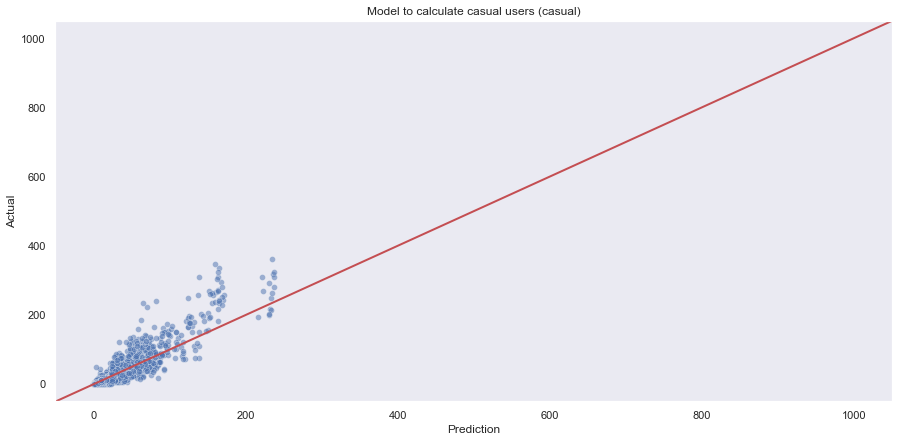

In [76]:
plt.figure(figsize=(15,7))
sns.scatterplot(x=y_hat_casual, y=y_test_casual, alpha=0.5)
plt.axline((0, 0), (1000, 1000), linewidth=2, color='r')
plt.xlabel('Prediction') 
plt.ylabel('Actual') 
plt.title("Model to calculate casual users (casual)")
plt.show()

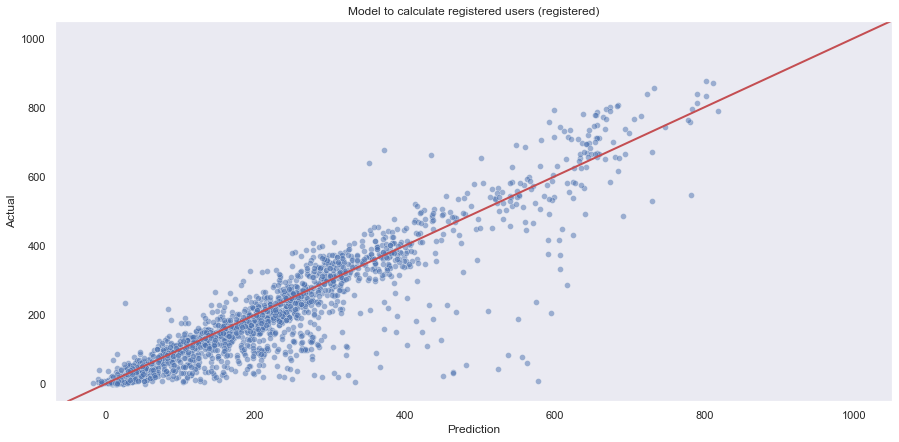

In [77]:
plt.figure(figsize=(15,7))
sns.scatterplot(x=y_hat_registered, y=y_test_registered, alpha=0.5)
plt.axline((0, 0), (1000, 1000), linewidth=2, color='r')
plt.xlabel('Prediction') 
plt.ylabel('Actual') 
plt.title("Model to calculate registered users (registered)")
plt.show()

Now we plot the results with an interactive widget so we can see the part of the DF we are interested in

In [78]:
%matplotlib inline
from ipywidgets import interactive

def f(lower_limit, hieger_limit):
    plt.figure(figsize=(20,6))
    plt.plot(X_test[lower_limit:hieger_limit].index, y_hat[lower_limit:hieger_limit], label='line')
    plt.plot(X_test[lower_limit:hieger_limit].index, y_test[lower_limit:hieger_limit], label='line')
    plt.show()
    
interactive_plot = interactive(f, lower_limit=(0, len(X_test)), hieger_limit=(0, len(X_test)))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=1084, description='lower_limit', max=2168), IntSlider(value=1084, descri…